# Demonstration of Bayesian QNM Fits

This is a tutorial / demonstration of the main functions used in this code. 

## Basic likelihood (amplitudes only) 

In [18]:
import qnmfits
import numpy as np
import scipy
import corner
from funcs.likelihood_funcs import *
from funcs.CCE import * 
from funcs.kernel_param_funcs import *
from funcs.GP_funcs import *
from funcs.qnm_selecting_funcs import * 

We start by importing a simulation (as a qnmfits.Custom object). We obtain the remnant mass and spin (which we denote with _0 in code and as a subscript * in the written notes). We also choose a start time for the fit, and modes to include in the model.  

In [55]:
id = "0001"

sim_main = SXS_CCE(id, lev="Lev5", radius="R2")

n_max = 6

T0 = 17
T = 100

qnm_list = [(2,2,n,1) for n in np.arange(0, n_max+1)]
spherical_modes = [(2, 2)]

chif_mag_0 = sim_main.chif_mag
Mf_0 = sim_main.Mf

Next, we determine the least squares amplitudes. The C_0 list can be used when we include Mf and/or Chif as parameters (otherwise it isn't needed). We hereafter treat the real and imaginary QNM amplitude as separate parameters, included in sequence in the true_params list. 

In [56]:
ls_fit = qnmfits.multimode_ringdown_fit(
    sim_main.times,
    sim_main.h,
    modes=qnm_list,
    Mf=Mf_0,
    chif=chif_mag_0,
    t0=T0,
    T=T,
    spherical_modes=spherical_modes,
)

C_0 = ls_fit["C"]

true_params = []
for re_c, im_c in zip(np.real(ls_fit["C"]), np.imag(ls_fit["C"])):
    true_params.append(re_c)
    true_params.append(im_c)

The kernel parameters are pre-saved in the tuned_params file. However, for the white noise, these need to be computed using the tuned value. 

In [57]:
# Get the standard kernel parameters

with open('tuned_params.pkl', 'rb') as f:
    params = pickle.load(f)

tuned_param_dict_main = params[id]

In [ ]:
# The training / tuning is demonstrated in the `get_kernel_params` file and notebook. 

with open('param_dict_sim_lm_full.pkl', 'rb') as f:
    param_dict_sim_lm = pickle.load(f)

tuning_hyperparams_s = [0.3239257812499994]  

hyperparam_rule_dict_s = {
    "sigma_max": "multiply",
}

tuned_param_dict_wn = {mode: get_new_params(param_dict_sim_lm[id][mode], tuning_hyperparams_s, hyperparam_rule_dict_s) for mode in param_dict_sim_lm[id]}

We now use the QNM BGP fit to do Bayesian fit with our chosen kernels

In [59]:
# White noise kernel

fit_wn = qnm_BGP_fit(
        sim_main.times,
        sim_main.h,
        qnm_list,
        Mf_0,
        chif_mag_0,
        T0,
        tuned_param_dict_wn,
        kernel_s,
        t0_method="geq",
        T=T,
        spherical_modes=spherical_modes,
    )

# Standard kernel 

fit_main = qnm_BGP_fit(
        sim_main.times,
        sim_main.h,
        qnm_list,
        Mf_0,
        chif_mag_0,
        T0,
        tuned_param_dict_main,
        kernel_main,
        t0_method="geq",
        T=T,
        spherical_modes=spherical_modes,
    )

Let's marginalise out the overtones above $n=1$.

In [84]:
param_list = [qnm for qnm in qnm_list for _ in range(2)]
parameter_choice = [(2,2,0,1), (2,2,1,1)]

indices = [i for i, param in enumerate(param_list) if param in parameter_choice]

marginal_mean_main, marginal_fisher_main = marginalise(parameter_choice, param_list, fit_main["mean"], fit_main["fisher_matrix"])
marginal_mean_wn, marginal_fisher_wn = marginalise(parameter_choice, param_list, fit_wn["mean"], fit_wn["fisher_matrix"])

marginal_covariance_main = np.linalg.inv(marginal_fisher_main)    
marginal_covariance_wn = np.linalg.inv(marginal_fisher_wn)

In [85]:
samples_main = scipy.stats.multivariate_normal(
    marginal_mean_main, marginal_covariance_main, allow_singular=True
).rvs(size=10000)

samples_wn = scipy.stats.multivariate_normal(
    marginal_mean_wn, marginal_covariance_wn, allow_singular=True
).rvs(size=10000)

In [86]:
labels = [
    r"$\mathrm{Re}(A_{(2,2,0,1)})$",
    r"$\mathrm{Im}(A_{(2,2,0,1)})$",
    r"$\mathrm{Re}(A_{(2,2,7,1)})$",
    r"$\mathrm{Im}(A_{(2,2,7,1)})$",
]

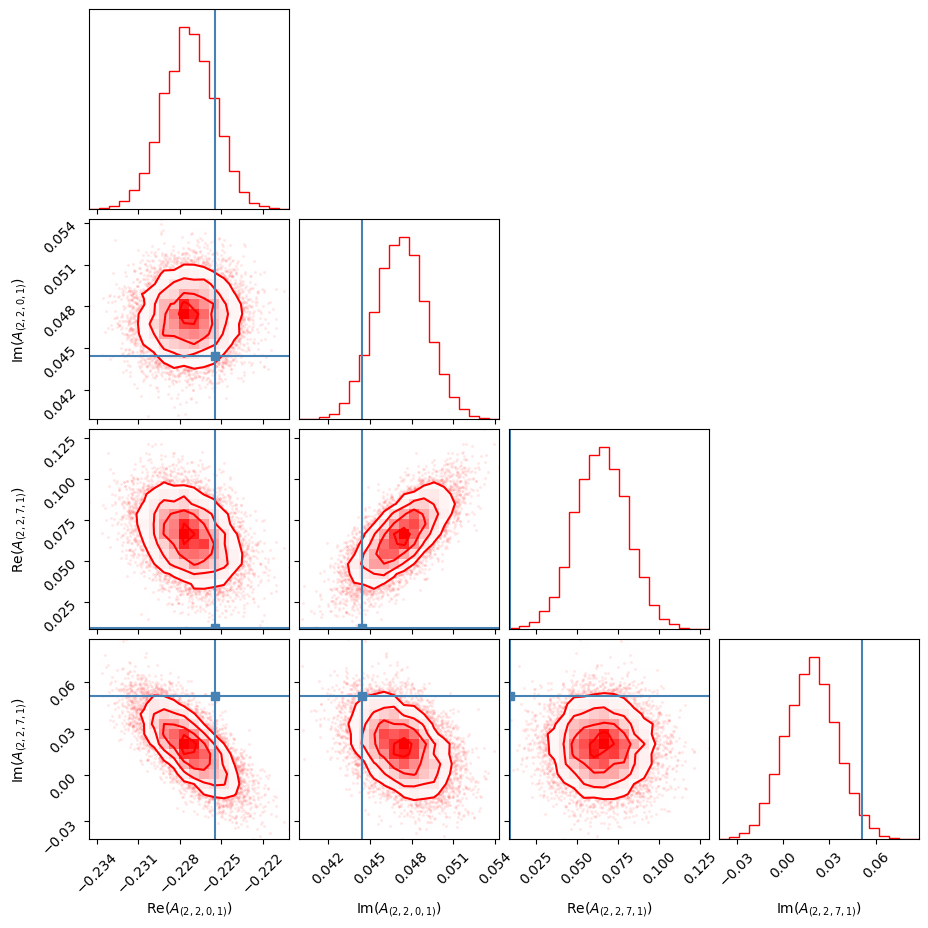

In [87]:
figure = corner.corner(
    samples_main,
    color='red',
    truths=[true_params[i] for i in indices],
    labels=labels,
)

and compare to the white noise case (which gives MAP values identical to least squares values) 

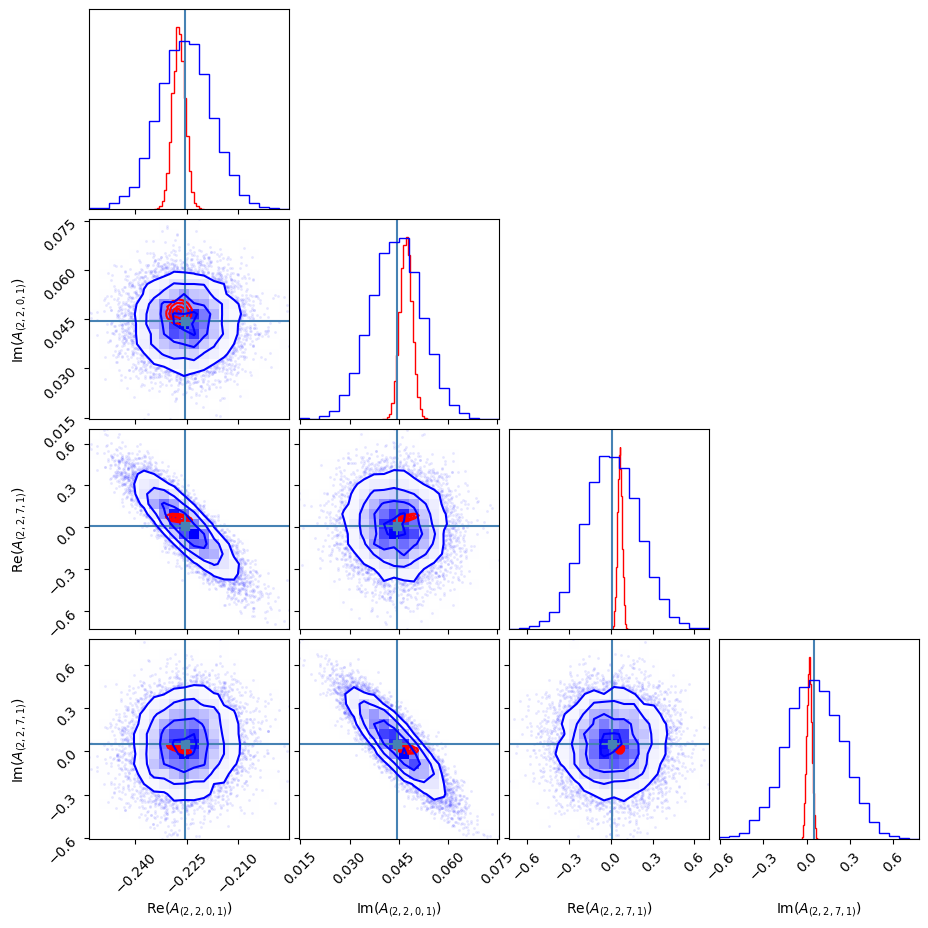

In [88]:
figure = corner.corner(
    samples_main,
    color='red',
    truths=[true_params[i] for i in indices],
    labels=labels,
)

figure = corner.corner(
    samples_wn,
    color='blue',
    labels=labels,
    fig=figure
)

## Including mass and spin

We can also include the mass and spin as parameters in the model. In practise they are included as the final two elements in parameter lists:

$[\rm Re(A_1), \rm Im(A_1), \rm Re(A_2), \rm Im(A_2), \dots, \chi_f, M_f]$.

To include these, set the appropriate boolean arguments in get_fisher_matrix, get_b_vector. C_0 also needs to be set to the the list obtained from the least-squares fit, and the true_param values need to be added to the mean vector.  The reason for avoiding these in the amplitude-only case is to save us having to compute the least-squares fit (because, in this case, only $M_*$ and $\chi_*$ are needed). 

Currently this isn't directly implemented into the get_BGP_fit function but we can bypass those and use the get_fisher_matrix and get_b_vector functions directly. 

In [92]:
true_params_full = true_params + [chif_mag_0, Mf_0]

In [ ]:
data_mask = (sim_main.times >= T0 - 1e-9) & (sim_main.times < T0 + T)

analysis_times = sim_main.times[data_mask]
data = {mode: sim_main.h[mode][data_mask] for mode in sim_main.h}

noise_covariance_matrix = get_GP_covariance_matrix(
        analysis_times, kernel_main, tuned_param_dict_main, spherical_modes
    )

In [101]:
fisher_matrix_main = get_fisher_matrix(
    qnm_list,
    spherical_modes,
    analysis_times,
    Mf_0,
    chif_mag_0,
    noise_covariance_matrix,
    C_0=C_0,
    include_chif=True,
    include_Mf=True,
)

b_vec_main = get_b_vector(
    qnm_list,
    spherical_modes,
    analysis_times,
    data,
    Mf_0,
    chif_mag_0,
    noise_covariance_matrix,
    C_0=C_0,
    include_chif=True,
    include_Mf=True,
)

Note that the mean vector is now cov_matrix @ b PLUS theta_0 (the true parameter values)


In [102]:
mean_vector_main = np.linalg.solve(fisher_matrix_main, b_vec_main) + true_params_full

In [103]:
param_list = [qnm for qnm in qnm_list for _ in range(2)] + ["chif"] + ["Mf"]
parameter_choice = ["chif", "Mf"]

indices = [i for i, param in enumerate(param_list) if param in parameter_choice]

marginal_mean_main, marginal_fisher_main = marginalise(parameter_choice, param_list, mean_vector_main, fisher_matrix_main)
marginal_covariance_main = np.linalg.inv(marginal_fisher_main)    

In [104]:
samples = scipy.stats.multivariate_normal(
    marginal_mean_main, marginal_covariance_main, allow_singular=True
).rvs(size=10000)

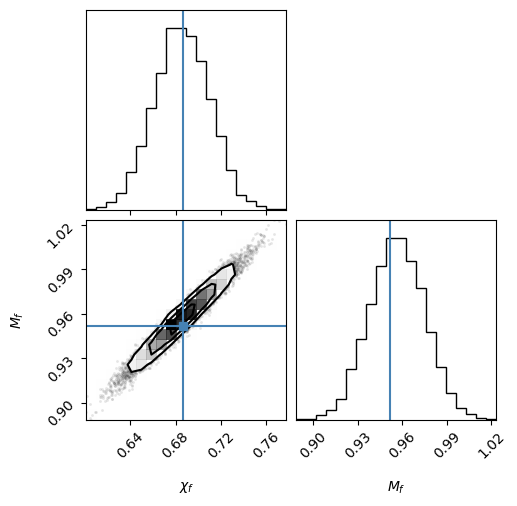

In [107]:
labels = [
    r"$\chi_f$",
    r"$M_f$",
]

figure = corner.corner(
    samples,
    truths=[true_params_full[i] for i in indices],
    labels=labels,
)